# 天球坐标系

- [Astronomical coordinate systems](https://en.wikipedia.org/wiki/Astronomical_coordinate_systems)
- [Astronomical Coordinates 1: Getting Started with astropy.coordinates](https://learn.astropy.org/tutorials/1-Coordinates-Intro.html)
- [Astronomical Coordinates 2: Transforming Coordinate Systems and Representations](https://learn.astropy.org/tutorials/2-Coordinates-Transforms.html)

## 知识点 1

- [ICRS](https://arxiv.org/pdf/astro-ph/0602086.pdf) 是常用的坐标系统，也称为赤道 (equatorial) 坐标系或 J2000 坐标系
- astropy 中默认就采用 ICRS
- 角度的多种表示方法
  - degree / degree minute second (dms)
  - radian
  - hour minute second (hms) / hourangle
- 3D 坐标，除了 ra, dec，还增加了距离信息

## 知识点 2

- coordinate 承担了太多意思，需要用其他术语进行明确区分指代，具体包含
  - Component Format: dms, degree, ...
  - Representation: Spherical (default), Cartesian, Cylindrical, ...
  - Frame: ICRS (default), galactic, ...

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from astropy import units as u
from astropy.coordinates import SkyCoord, Distance, Galactic, EarthLocation, AltAz
import astropy.coordinates as coord
from astropy.io import fits
from astropy.table import QTable
from astropy.time import Time
from astropy.utils.data import download_file

In [2]:
c = SkyCoord(ra=15.9932*u.deg, dec=-10.52351344*u.deg)
c

<SkyCoord (ICRS): (ra, dec) in deg
    (15.9932, -10.52351344)>

### Representations

转换方法 1

In [9]:
# 1st transformation, the default is in a unit sphere if distance is not given.
c.represent_as('cartesian')  # recommended

<CartesianRepresentation (x, y, z) [dimensionless]
    (0.94512547, 0.27088898, -0.18263903)>

In [5]:
# list all transformation, or find here -- 
# https://docs.astropy.org/en/stable/coordinates/representations.html#astropy-coordinates-representations
print([x for x in dir(coord) 
       if x.endswith('Representation') and not x.startswith('Base')])

['CartesianRepresentation', 'CylindricalRepresentation', 'GRS80GeodeticRepresentation', 'PhysicsSphericalRepresentation', 'RadialRepresentation', 'SphericalRepresentation', 'UnitSphericalRepresentation', 'WGS72GeodeticRepresentation', 'WGS84GeodeticRepresentation']


转换方法 2

In [8]:
# 2nd transformation
c2 = c.cartesian
c2

<CartesianRepresentation (x, y, z) [dimensionless]
    (0.94512547, 0.27088898, -0.18263903)>

转换方法 3

In [15]:
# 3rd transformation
c3 = SkyCoord(ra=15.9932 * u.deg, 
              dec=-10.52351344 * u.deg,
              distance=127.4 * u.pc)
print(c3.representation_type)
print(c3, '\n')


c3.representation_type = coord.CylindricalRepresentation
print(c3.representation_type)   # Note: c3 has been changed
print(c3)

<class 'astropy.coordinates.representation.SphericalRepresentation'>
<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)
    (15.9932, -10.52351344, 127.4)> 

<class 'astropy.coordinates.representation.CylindricalRepresentation'>
<SkyCoord (ICRS): (rho, phi, z) in (pc, deg, pc)
    (125.2571368, 15.9932, -23.2682118)>


### Frames

In [21]:
# load data
tbl = QTable.read('Cantat-Gaudin-open-clusters.csv')

open_cluster_c = SkyCoord(
    ra=tbl['RAJ2000'],
    dec=tbl['DEJ2000'],
    distance=tbl['dmode'],
    frame='icrs',
    unit='deg')
len(open_cluster_c)

1229

In [23]:
open_cluster_c[:4]

<SkyCoord (ICRS): (ra, dec, distance) in deg
    [( 51.87 , 34.981, 672. ), (288.399, 36.369, 397.3),
     (295.548, 27.366, 551.8), (297.164, 21.987, 878.5)]>

In [24]:
def coordinates_aitoff_plot(coords):
    fig, ax = plt.subplots(figsize=(10, 4), 
                           subplot_kw=dict(projection="aitoff"))  # Projection
    
    sph = coords.spherical
    cs = ax.scatter(-sph.lon.wrap_at(180*u.deg).radian,
                    sph.lat.radian,
                    c=sph.distance.value)

    def fmt_func(x, pos):
        val = coord.Angle(-x*u.radian).wrap_at(360*u.deg).degree
        return f'${val:.0f}' + r'^{\circ}$'

    ticker = mpl.ticker.FuncFormatter(fmt_func)
    ax.xaxis.set_major_formatter(ticker)

    ax.grid()
    
    cb = fig.colorbar(cs)
    cb.set_label('distance [pc]')
    
    return fig, ax

Equatorial

Text(0, 0.5, 'Dec [deg]')

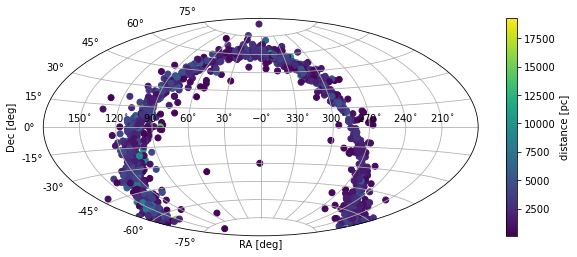

In [25]:
fig, ax = coordinates_aitoff_plot(open_cluster_c)
ax.set_xlabel('RA [deg]')
ax.set_ylabel('Dec [deg]')

Galactic

In [32]:
# 1st way
open_cluster_gal = open_cluster_c.transform_to(Galactic())  # recommended

# 2nd way
# open_cluster_gal = open_cluster_c.galactic  

Text(0, 0.5, 'Galactic latitude, $b$ [deg]')

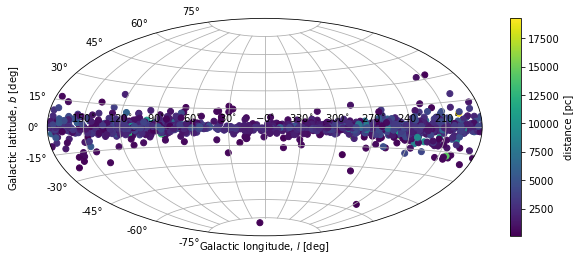

In [33]:
fig, ax = coordinates_aitoff_plot(open_cluster_gal);
ax.set_xlabel('Galactic longitude, $l$ [deg]')
ax.set_ylabel('Galactic latitude, $b$ [deg]')

### Component Format

In [38]:
# 以 (RA, DEC) = (12.11°, 85.26°) 为例
ngc188_center = SkyCoord(12.11*u.deg, 85.26*u.deg)
ngc188_center

<SkyCoord (ICRS): (ra, dec) in deg
    (12.11, 85.26)>

In [42]:
# 时分秒 + 角分秒，hms + dms
SkyCoord('00h48m26.4s', '85d15m36s', frame='icrs')

<SkyCoord (ICRS): (ra, dec) in deg
    (12.11, 85.26)>

In [35]:
# 时分秒 + 角分秒，: 作为分隔符
SkyCoord('00:48:26.4 85:15:36', unit=(u.hour, u.deg), 
         frame='icrs')

<SkyCoord (ICRS): (ra, dec) in deg
    (12.11, 85.26)>

In [17]:
ngc188_center.ra.to_string(unit=u.hourangle)

'0h48m26.4s'

## Visualization and Projection